# Delay Calculation Validation Experiments

- Note that you'll have to be on an updated branch ... (to be pushed pending exising PRs)
     - There is way to much going on in the current PRs, don't want to add complexity just yet

In [1]:
import os, os.path as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from RAiDER.llreader import BoundingBox
from RAiDER.losreader import Zenith, Conventional, Raytracing
from RAiDER.delay import tropo_delay
from RAiDER.utilFcns import (
    lla2ecef, transform_bbox, clip_bbox, writeResultsToXarray,
    rio_profile,
)
import yaml
%matplotlib inline
%pdb off

# change this to the directory with the notebook
wd = op.join(op.expanduser('~'), 'Software_InSAR','RAiDER-docs_git','notebooks', 'Synthetic_Test')
WM = 'GMAO'
yaml_GUNW = f'{wd}/GUNW_Base.yaml' # manually created

os.chdir(wd)
print ('Working directory (WD):', wd)

Automatic pdb calling has been turned OFF
Working directory (WD): /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test


### helper functions

update_wm is the one to edit

In [2]:
def compare_golden(wd, ext='ray'):
    """ Quick check if the synth result is different than real weather wm """
    ds_orig = xr.open_dataset(f'{wd}/golden_data/GMAO_tropo_20181113T230000_{ext}.nc')
    da_dry0 = ds_orig['hydro']
    ds_new  = xr.open_dataset(f'{wd}/Synthetic_tropo_20181113T110000_{ext}.nc')
    da_dry1 = ds_new['hydro']
    equal = np.allclose(da_dry0.data, da_dry1.data, equal_nan=True)
    print ('Orig == synthetic?', equal)
    return

In [3]:
def new_yaml_group(example_yaml, dct_group, dst='tmp.yaml'):
    """ Write a temporary yaml file with the new 'value' for 'key', preserving parms in example_yaml"""
    with open(example_yaml, 'r') as f:
        try:
            params = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
            raise ValueError(f'Something is wrong with the yaml file {example_yaml}')

    params = {**params, **dct_group}
    dst = op.join(os.path.dirname(example_yaml), dst)
    
    with open(dst, 'w') as fh:
        yaml.dump(params, fh, default_flow_style=False)
    
    print ('Wrote new cfg file:', dst)
    return dst


## Get/Set defaults

In [64]:
## Mimic test_scenario_3.py
# dt  = datetime(2018, 11, 13, 23)
# dts = dt.strftime('%Y_%m_%d_T%H_%M_%S')

# height_levels = np.array([0., 100., 500., 1000.])
# aoi = BoundingBox([36.8, 36.85, -76.15, -76.05])
# # aoi.add_buffer(buffer=1.)

# # get redownload (with change to name) with !eof -m S1A -d {dts.replace('_', '')}
# orbit = f'{WD}/S1A_OPER_AUX_POEORB_OPOD_20181203T120749_V20181112T225942_20181114T005942.EOF'

In [4]:
## Mimic LA_ARIA GUNW

dt  = datetime(2020, 1, 30, 13, 52, 45)
dts = dt.strftime('%Y_%m_%d_T%H_%M_%S')

hgt_lvls = np.array([0., 100., 500., 1000.])
S, N, W, E   = 33, 34, -118.25, -117.25 # 32.979829, 34.944592, -119.272279, -116.251959
aoi = BoundingBox([S,N,W,E])

aoi.add_buffer(buffer = 1.5 * 0.3125)#model.getLLRes())

# aoi.add_buffer(buffer=1.)
orbit = f'{wd}/S1B_OPER_AUX_POEORB_OPOD_20210317T025713_V20200129T225942_20200131T005942.EOF'
los = Raytracing(orbit, time=dt)
grid_spacing = 0.5

# f_lat, f_lon = makeLatLonGrid([S, N, W, E], 'LA', f'{wd}/data', grid_spacing)


In [40]:
from RAiDER.models.gmao import GMAO


# play with the ks for different scenarios (think about moving constants around with integral)
class GMAOdummy(GMAO):
    def __init__(self, shp=(12, 14, 145), k1=1):
        super().__init__()
#         self.shp = (13, 12, 145) # unique to this study area (145 height levels)
#         self.shp = (21, 22, 145) # unique to this study area (145 height levels)
        self.shp = shp
        self._k1 = k1# 0.776  # [K/Pa]
        self._k2 = 0# 0.233  # [K/Pa]
        self._k3 = 0# 3.75e3  # [K^2/Pa]
        self._p  = np.ones(self.shp) 
        self._t  = self._p
        self._e  = np.zeros(self.shp) 

        self._zs = self._zlevels # model levels
#         self._zs = np.ones(self.shp[-1])

        self._getZTD()
    
        self._out_name = f'{wd}/weather_files/dummy.nc'
        self._time = dt
        self._xs = np.array([-119.375, -119.0625, -118.75, -118.4375, -118.125,  -117.8125, -117.5,  -117.1875, -116.875,  -116.5625, -116.25,  -115.9375, -115.625,  -115.3125])
        self._ys = np.array([32., 32.25, 32.5 , 32.75, 33.  , 33.25, 33.5 , 33.75, 34., 34.25, 34.5, 34.75])
              

    def _get_wet_refractivity(self):
        '''
        Calculate the wet delay from pressure, temperature, and e
        '''
        self._wet_refractivity = self._k2 * self._e / self._t + self._k3 * self._e / self._t**2
        return self._wet_refractivity
    
    def _get_hydro_refractivity(self):
        '''
        Calculate the hydrostatic delay from pressure and temperature
        '''
        self._hydrostatic_refractivity = self._k1 * self._p / self._t
        return self._hydrostatic_refractivity
    
    def getWetRefractivity(self):
        return self._wet_refractivity

   
    def getHydroRefractivity(self):
        return self._hydrostatic_refractivity

   
    def _getZTD(self, zref=None):
        self._get_wet_refractivity()
        self._get_hydro_refractivity()
        wet   = self.getWetRefractivity()
        hydro = self.getHydroRefractivity()


        # Get the integrated ZTD
        wet_total, hydro_total = np.zeros(wet.shape), np.zeros(hydro.shape)
        for level in range(wet.shape[2]):
            wet_total[..., level] = 1e-6 * np.trapz(
                wet[..., level:], x=self._zs[level:], axis=2
            )
            hydro_total[..., level] = 1e-6 * np.trapz(
                hydro[..., level:], x=self._zs[level:], axis=2
            )
        self._hydrostatic_ztd = hydro_total
        self._wet_ztd = wet_total
        return

In [39]:
def update_GMAO(wm_file, k1=7):
    Obj = GMAOdummy(k1=k1)
    wet = Obj.getWetRefractivity()
    dry = Obj.getHydroRefractivity()
    wet_total = Obj._wet_ztd
    dry_total = Obj._hydrostatic_ztd
    with xr.open_dataset(wm_file) as ds:
        ds['wet']   = ('z y x'.split(), wet.transpose(2, 0, 1))
        ds['hydro'] = ('z y x'.split(), dry.transpose(2, 0, 1))
        
       
        ds['wet_total']   = ('z y x'.split(), wet_total.transpose(2, 0, 1))
        ds['hydro_total'] = ('z y x'.split(), dry_total.transpose(2, 0, 1))
        
    dst = f'{op.splitext(wm_file)[0]}_SYNTH.nc'.replace('_REAL', '')
    os.remove(dst) if op.exists(dst) else ''
    ds.to_netcdf(dst)
    print ('Wrote synthetic weather model file to:', dst)
    return dst

In [22]:
def update_wm0(wm_file, wet, dry, dry_total=None, wet_total=None):
    """ Edit the pointwise? values in a weather model file 

    write it out with extension _SYNTH
    Return the file name for input into tropo_delay

    wet_total/hydro_total used for zenith/proj
    wet/hydro used for ray
    """
    with xr.open_dataset(wm_file) as ds:
        ds['wet']   = ('z y x'.split(), wet)
        ds['hydro'] = ('z y x'.split(), dry)
        
        if wet_total:
            ds['wet_total']   = ('z y x'.split(), wet_total)
        if dry_total:
            ds['hydro_total'] = ('z y x'.split(), dry_total)
        
    dst = f'{op.splitext(wm_file)[0]}_SYNTH.nc'
    ds.to_netcdf(dst)
    print ('Wrote synthetic weather model file to:', dst)
    return dst


# Test One

- k1 = a number; 
- P=T; 
- k2=k3=0; 

integral would be k1*ray-length. 
Note you could one time make P=T=without lateral variation and once time with variations.


In [10]:
S, N, W, E

(33, 34, -118.25, -117.25)

In [69]:
np.round(grid_spacing/1e-5).astype(np.float32)

1000.0

In [11]:
## run it through with the real weather model file
grp = {
       'aoi_group': {'bounding_box': [S,N,W,E]},
        'height_group': {#'dem': 'GLO30_fullres_dem.tif', 
                         'height_levels': hgt_lvls.tolist(),
                        },
        'date_group': {'date_list': datetime.strftime(dt, '%Y%m%d')},
        'cube_spacing_in_m': round(grid_spacing/1e-5),
        'los_group': {'ray_trace': True, 'orbit_file': orbit},
        'weather_model': WM
      }

cfg = new_yaml_group(yaml_GUNW, grp)
!raider.py {cfg}

Wrote new cfg file: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/tmp.yaml
Invalid extension GTiff for cube. Defaulting to .nc
Starting to run the weather model calculation
Date: 20200130
Beginning weather model pre-processing
Extent of the weather model is (xmin, ymin, xmax, ymax):-119.38, 32.00, -115.31, 34.75
Extent of the input is (xmin, ymin, xmax, ymax): -118.72, 32.53, -116.22, 34.47
Output SNWE: [32.5, 34.5, -119.0, -116.5]
Output cube spacing: 0.5
Processing slice 1 / 4: 0.0
Processing slice 2 / 4: 100.0
Processing slice 3 / 4: 500.0
Processing slice 4 / 4: 1000.0

Successfully wrote delay cube to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/GMAO_tropo_20200130T135245_ray.nc



In [41]:
wm_file0 = op.join(wd, 'weather_files/GMAO_2020_01_30_T13_52_45_33N_35N_120W_116W_REAL.nc')
wm_file1 = update_GMAO(wm_file0)


ds  = tropo_delay(dt, wm_file1, aoi, los, hgt_lvls, cube_spacing_m=round(grid_spacing/1e-5))[0]
da  = ds['hydro']

Wrote synthetic weather model file to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/weather_files/GMAO_2020_01_30_T13_52_45_33N_35N_120W_116W_SYNTH.nc
Output SNWE: [32.5, 34.5, -119.0, -116.5]
Output cube spacing: 0.5
Processing slice 1 / 4: 0.0
Processing slice 2 / 4: 100.0
Processing slice 3 / 4: 500.0
Processing slice 4 / 4: 1000.0


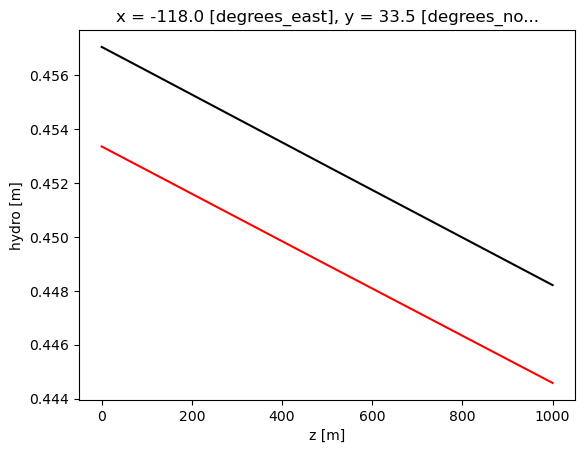

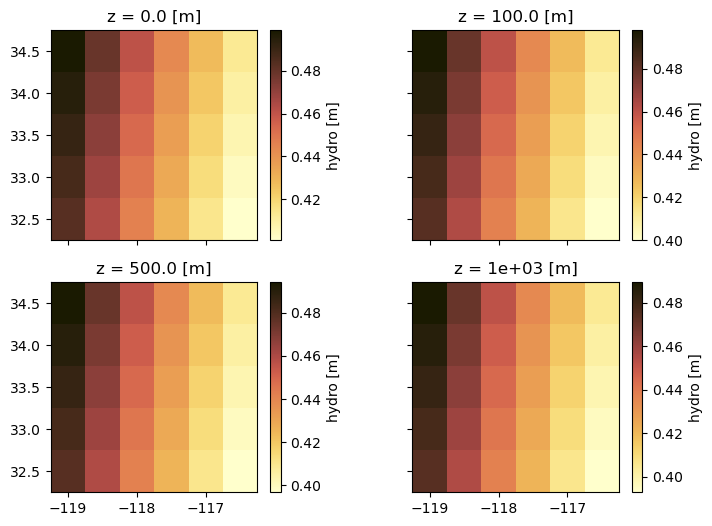

Min: 0.393
Any nan: False


In [44]:
lalo_ix = (1,2) # random index of lat lon

fig, axes = plt.subplots()
da.isel(y=lalo_ix[0], x=lalo_ix[1]).plot(ax=axes, color='k')
da.isel(y=lalo_ix[0]+1, x=lalo_ix[1]).plot(ax=axes, color='red');


fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(8,6))
for i, ax in enumerate(axes.ravel()):
    da.isel(z=i).plot(ax=ax, cmap='cmc.lajolla')#, vmin=0.058, vmax=0.061)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.subplots_adjust(wspace=0.4)
plt.show()

print ('Min:', round(da.min().item(), 3))
print ('Any nan:', da.isnull().any().item())

In [110]:
from RAiDER.losreader import getTopOfAtmosphere
from RAiDER.utilFcns import lla2ecef, ecef2lla


def build_ray(los, hgt_lvls, model_zs, k1):
    """ This builds rays only; no impact of delays """
    model_zs = GMAOdummy()._zs
    zpts = hgt_lvls
    ypts = np.array([34.5, 34. , 33.5, 33. , 32.5])
    xpts = np.array([-119. , -118.5, -118. , -117.5, -117. , -116.5])

    # Create a regular 2D grid
    xx, yy = np.meshgrid(xpts, ypts)

    outputArrs = np.zeros((zpts.size, ypts.size, xpts.size))
    # iterate over height levels
    for hh, ht in enumerate(hgt_lvls):
        outSubs = outputArrs[hh, ...] # a 2d array where output is stored and added to (at one heihgt level)
        cos_factor = None
        zzs = []
        # iterate over all model levels
        nn=0
        for zz in range(model_zs.size-1):
            low_ht = model_zs[zz]
            high_ht = model_zs[zz + 1]

            if (high_ht <= ht) or (low_ht >= 50000):
                continue
            
            # If high_ht > max_tropo_height - integral only up to max tropo
            if high_ht > 50000:
                high_ht = 50000
                
            # If low_ht < height of point - integral only up to height of point
            if low_ht < ht:
                low_ht = ht

            llh = [xx, yy, np.full(yy.shape, ht)]

            xyz = np.stack(lla2ecef(llh[1], llh[0], np.full(yy.shape, ht)), axis=-1)
            LOS = los.getLookVectors(ht, llh, xyz, yy)

            low_xyz = getTopOfAtmosphere(xyz, LOS, low_ht, factor=cos_factor)
            high_xyz = getTopOfAtmosphere(xyz, LOS, high_ht, factor=cos_factor)
            ray_length = np.linalg.norm(high_xyz - low_xyz, axis=-1)
                           
            nParts = int(np.ceil(ray_length.max() / 1000)) + 1

            if cos_factor is None:
                cos_factor = (high_ht - low_ht) / ray_length

            # fractions of ray
            fracs = np.linspace(0., 1., num=nParts)

            # Integrate over the ray
            for findex, ff in enumerate(fracs):
                # Trapezoidal integration with scaling
                wt   = 0.5 if findex in [0, fracs.size-1] else 1.0
                wt  *= ray_length * 1.0e-6 / (nParts - 1.0)
                outSubs += wt * k1
                nn+1 # counter for stopping
        print (outSubs.mean())

    return outputArrs

dat = build_ray(los, hgt_lvls, GMAOdummy()._zs, k1=7.0)

0.44670261773735187
0.44583660151027193
0.4423715502802249
0.43803801212716975


In [126]:
ds = xr.open_dataset(f'{wd}/{WM}_tropo_20200130T135245_ray.nc')
da = ds['hydro']

print (np.allclose(dat[0], da.data[0])) # true
print (np.allclose(dat[1], da.data[1])) # true

print (np.allclose(dat[2], da.data[2])) # False?

print (np.allclose(dat[3], da.data[3])) # true

print (np.allclose(dat, da.data, atol=1e-5)) # slightl
ds.close()

True
True
False
True
True


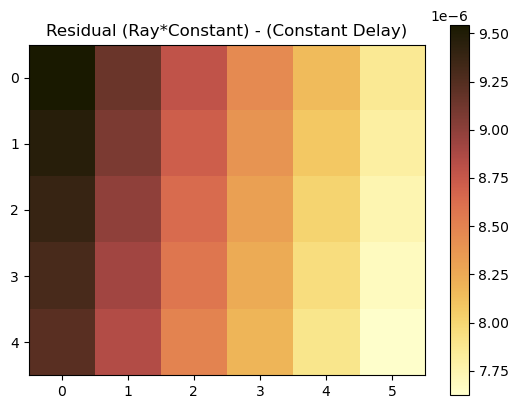

In [134]:
%matplotlib inline
# plt.switch_backend('MacOSX')
plt.imshow(dat[2] - da.data[2], cmap='cmc.lajolla')
plt.title('Residual (Ray*Constant) - (Constant Delay)')
plt.colorbar();

## Hack Weather Model

- give fake constants, p, e, t and use to calculate wet and dry
- original weather model file can be redownloaded with !raider.py raider_example_3.yaml

In [ ]:
# spatial variability will depend on interpolators
# use a [linear] ramp for analytically comparing
#  - dont vary in height; need to know integral exactly (so pick a easy functional form; let k1/k2 0 to get rid of higher terms)
# straight/known fn along profile = analytical form

# book keeping interpolation really

#^ after testing ray tracing in near/mid/far range

# take cube; know ray
# make linear function along ray; and then interpolate in 3d/nearest neighbor (e^x?)
# make temp = pres so cancel in integral
# k3 = 0; mess with the others to match / cancel out

## otherwise
# catch HRRR projection hardcoding over non-conus

In [8]:
Obj = GMAOdummy()
# Obj._getZTD()

wet = Obj._get_wet_refractivity().transpose(2,0,1)
dry = Obj._get_hydro_refractivity().transpose(2,0,1)

f   = op.join(WD, 'weather_files', 'GMAO_2020_01_30_T13_52_45_32N_37N_121W_115W.nc')
# f   = op.join(WD, 'weather_files', 'GMAO_2018_11_13_T23_00_00_36N_39N_78W_75W.nc')
dst = update_wm(f, wet=wet, dry=dry)
ds  = xr.open_dataset(dst)

NameError: name 'WD' is not defined

In [70]:
from RAiDER.utilFcns import (
    lla2ecef, transform_bbox, clip_bbox, writeResultsToXarray,
    rio_profile,
)

wm_proj = rio_profile(f"netcdf:{dst}:t")["crs"]
wm_proj

CRS.from_epsg(4326)

## Hack Orbit File

In [ ]:
import isce3.ext.isce3 as isce
from RAiDER.losreader import read_ESA_Orbit_file, cut_times, get_orbit

In [ ]:
## get the state vectors from the orbit file
# list of ndarrays of times, x/y/z positions and velocities in ECEF

svs = read_ESA_Orbit_file(orbit)
idx = cut_times(svs[0], dt, pad=6000)
svs = [d[idx] for d in svs]

In [ ]:
## create a N/S orbit by setting the E/W position to a constant
svs0 = svs.copy() # save original

# svs[1] = len(svs[0]) * [np.mean(svs[1])] # x
# svs[1] = len(svs[0]) * [np.median(svs[1])] # x

svs[1] = len(svs[1]) * [svs[1][0]] # x


# svs[4] = len(svs[4]) * [0]
# svs[3] = len(svs[0]) * [np.mean(svs[2])] # z

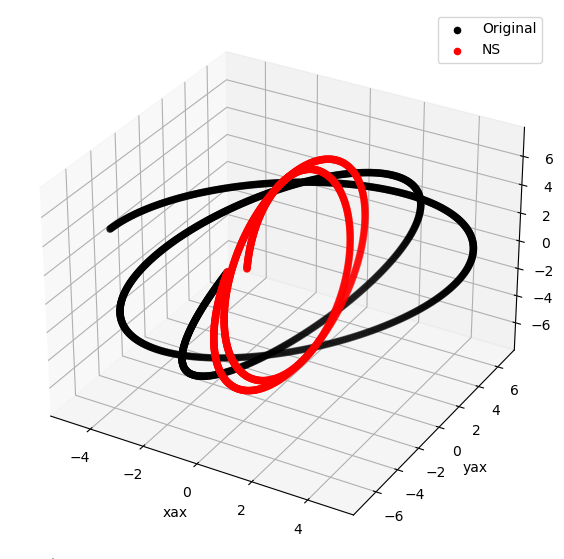

In [18]:
## plot the original and new orbit
%matplotlib inline

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(svs0[1], svs0[2], svs0[3], color='k', label='Original')
ax.scatter(svs[1], svs[2], svs[3], color='red', label='NS')


ax.set_xlabel('xax')
ax.set_ylabel('yax')
ax.set_zlabel('zax')
ax.legend();

# ax.view_init(elev=20., azim=-35, roll=0)

In [19]:
## create the orbit from the statevectors

# basically losreader.get_orbit
svs1  = np.stack(svs, axis=-1)
svs_i = []
for sv in svs1:
    sv = isce.core.StateVector(isce.core.DateTime(sv[0]), sv[1:4], sv[4:7])
    svs_i.append(sv)

orb = isce.core.Orbit(svs_i)

In [20]:
## create the points on the ground that correspond to the ORIGINAL wm file

from pyproj import CRS, Transformer
out_snwe = [32.9, 35.0, -119.30000000000001, -116.2]
out_spacing  = 0.1
xpts = np.arange(out_snwe[2], out_snwe[3] + out_spacing, out_spacing)
ypts = np.arange(out_snwe[1], out_snwe[0] - out_spacing, -out_spacing)

xx, yy = np.meshgrid(xpts, ypts)
pts_crs = CRS.from_epsg(4326)

ht  = 0
llh = [xx, yy, np.full(yy.shape, ht)]


xyz = np.stack(lla2ecef(llh[1], llh[0], np.full(yy.shape, ht)), axis=-1)

In [ ]:

def getLookVectors(self, ht, llh, xyz, yy):
    '''
    Calculate unit look vectors (from ground to satellite) for raytracing
    these gets grown in length step wise
    '''
    # TODO - Modify when isce3 vectorization is available
    los = np.full(yy.shape + (3,), np.nan)
    llh[0] = np.deg2rad(llh[0])
    llh[1] = np.deg2rad(llh[1])

    import isce3.ext.isce3 as isce

    for ii in range(yy.shape[0]):
        for jj in range(yy.shape[1]):
            inp = np.array([llh[0][ii, jj], llh[1][ii, jj], ht])
            inp_xyz = xyz[ii, jj, :]

            if any(np.isnan(inp)) or any(np.isnan(inp_xyz)):
                continue

            # Wavelength does not matter for
            try:
                aztime, slant_range = isce.geometry.geo2rdr(
                    inp, self._elp, self._orbit, self._dop, 0.06, self._look_dir,
                    threshold=1.0e-7,
                    maxiter=30,
                    delta_range=10.0)
                sat_xyz, _ = self._orbit.interpolate(aztime)
                los[ii, jj, :] = (sat_xyz - inp_xyz) / slant_range
            except Exception as e:
                los[ii, jj, :] = np.nan
    return los


In [21]:
## setup the raytracing to calculate the look vectors
los = Raytracing(orbit)
los._orbit = orb
los._time  = dt

LOS = los.getLookVectors(ht, llh, xyz, yy)
print ('All nan?', np.isnan(LOS).all())

All nan? True


In [ ]:
# los = Zenith()
# ext = 'ztd'

# los = Conventional(orbit)
# ext = 'std'

# los = Raytracing(orbit, time=dt)
# ext = 'ray'

# Misc

### Compute Delays

In [ ]:
ds  = tropo_delay(dt, wm, aoi, los, height_levels, cube_spacing_m=5000)[0]

In [ ]:
out = f'{WD}/Synthetic_tropo_20181113T110000_{ext}.nc'
ds.to_netcdf(out, mode="w")
print ('Wrote:', out)

### Check against analytical solutions

In [ ]:
compare_golden(WD)

## Questions

- is our hydrostatic equation missing a term?
ours: $$0.776 \frac{P_d}{T}$$
[Li et al, Eq. 2](https://amt.copernicus.org/articles/14/6379/2021/): $$0.776  \frac{P_d}{T} + 0.776 \frac{M_w}{M_d}\frac{P_w}{T}$$

where: $P_d$ (in hPa) is the partial pressure of the dry constituent, $P_w$ (in hPa) is the partial pressure of water vapor, T (in K) is the partial temperature. They don't define $M_w$ and $M_d$/

Meanwhile, from [Stephens et al., Eq. 4](https://www.mdpi.com/2072-4292/12/5/782)(also Jolivet): $$0.776  \frac{R_d}{9.8}(P)$$

where $R_d$ is the specific gas constants for dry air 

Agreement with [Bekaert et al., 2015](https://www.sciencedirect.com/science/article/pii/S0034425715301231):
$$k_1\left(\frac{P}{T}\right)_{hyd} + \left(k_2\frac{e}{T} + k_3\frac{e}{T}^2\right)_{wet}$$


I suppose we ignore the $P_w$ wrt Li et al., but why are we so different from Jolivet?


## Plot Orbits

In [ ]:
xs = np.ones(5)*5
ys = np.arange(5)*2
zs = np.arange(5)

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, color='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [58]:

xs  = svs0[1]
ys  = svs0[2]
zs  = svs0[3]

xs1 = svs[1]
ys1 = svs[2]
zs1 = svs[3]
# xx = np.arange(len(xs))
# xx = np.polyval(np.polyfit(xx, xs, 1), xx)
# xx

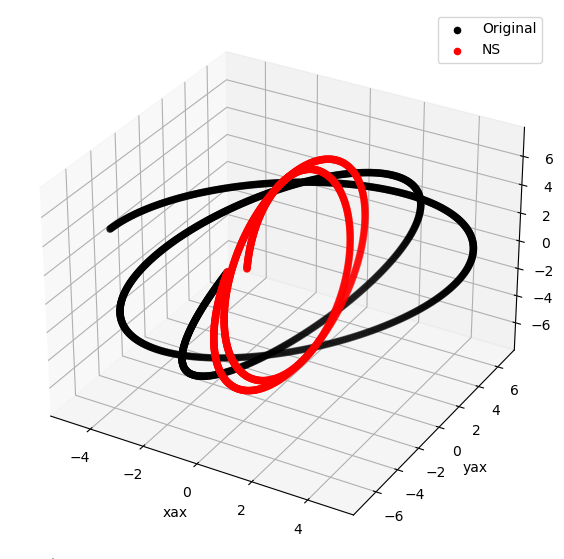

In [61]:
%matplotlib inline


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs, ys, zs, color='k', label='Original')
ax.scatter(xs1, ys1, zs1, color='red', label='NS')


ax.set_xlabel('xax')
ax.set_ylabel('yax')
ax.set_zlabel('zax')
ax.legend();

# ax.view_init(elev=20., azim=-35, roll=0)

# Orbit Math

## [Geometry Constlat](https://github.com/isce-framework/isce3/blob/0eb175f86f6c74d86c19ba9623f23054513fc657/tests/cxx/isce3/geometry/geometry/geometry_constlat.cpp)

This unit test compares output of geometry algorithms against analytic solutions
derived for a satellite flying at constant velocity and radius over a line of constant
latitude.
The target is assumed to lie on a sphere with radius equal to Ellipsoid's major axis.
### Geodetic LLH to ECEF XYZ
---------
Radius along the East-West direction ($R_e$) is given by:
$$R_e \left(\theta \right) = \frac{a}{\sqrt{1 - e^2 \cdot \sin^2 \left(\theta \right)}}$$
Using the East-West radius, a given target at Geodetic Latitude ($\theta$), Longitude ($\psi$)
and Height ($h$) can be transformed to Caresian ECEF coordinates as follows:
$$X = \left( R_e\left( \theta \right) + h \right) \cdot \cos \theta \cdot \cos \psi$$
$$Y = \left( R_e\left( \theta \right) + h \right) \cdot \cos \theta \cdot \sin \psi$$
$$Z = \left( R_e\left( \theta \right) \cdot \left( 1 - e^2 \right) +h \right) \cdot \sin \theta $$
### Parametric form of Sphere with Geocentric Latitude
-----------
A point $\vec{S}$ on a sphere at a height $h$ above the major axis characterized by Geocentric
Latitude ($\lambda$), Longitude ($\psi$) can be expressed in ECEF coordinates as follows:
$$ X = \left( a + h \right) \cdot \cos \lambda \cos \psi $$
$$ Y = \left( a + h \right) \cdot \cos \lambda \sin \psi $$
$$ Z = \left( a + h \right) \cdot \sin \lambda $$
### Target on same longitude as satellite is on Zero Doppler Countour
----------
Consider a target ($\vec{T}$) located on the same longitude as the satellite.
Let the location of target ($\vec{T}$) be represented by geocentric latitude $\lambda$,
longitude $\psi$ and zero height .
$$X_t = a \cdot \cos \lambda \cdot \cos \psi$$
$$Y_t = a \cdot \cos \lambda \cdot \sin \psi$$
$$Z_t = a \cdot \sin \lambda $$
Using the above expressions, it can be shown that
$$\left( \vec{R_{s}} - \vec{T} \right) \cdot \vec{V_{s}} = 0$$
Hence, it is sufficient to solve for Target latitude ($\lambda$) when estimating target
on reference surface of ellipsoid ($h_t$) for a given slant range for forward
geometry operations.
### Target on Geocentric sphere with radius a
-----------
For a given slant range ($R$), we can write out
$$ \left( \left( a + h_s \right) \cdot \cos \lambda_s  -   a \cdot \cos \lambda \right)^2$$
$$ + \left( \left( a +h_s \right) \cdot \sin \lambda_s - a \cdot \sin \lambda \right)^2 = R^2$$
Leading to
$$\cos \left( \lambda - \lambda_s \right) = \frac{1}{2} \cdot \left[ \frac{a+h_s}{a} + \frac{a}{a+h_s} - \frac{R}{a} \cdot \frac{R}{a+h_s} \right] $$

## [Geometry Equator](https://github.com/isce-framework/isce3/blob/0eb175f86f6c74d86c19ba9623f23054513fc657/tests/cxx/isce3/geometry/geometry/geometry_equator.cpp)

-------------
This unit tests compares output of geometry algorithms against analytic solutions
derived for a satellite flying at constant velocity and height over the equator.
The target is assumed to lie on the reference Ellipsoid.
## Geodetic LLH to ECEF XYZ
---------
Radius along the East-West direction ($R_e$) is given by:
$$R_e \left(\theta \right) = \frac{a}{\sqrt{1 - e^2 \cdot \sin^2 \left(\theta \right)}}$$
Using the East-West radius, a given target at Geodetic Latitude ($\theta$), Longitude ($\psi$)
and Height ($h$) can be transformed to Caresian ECEF coordinates as follows:
$$X = \left( R_e\left( \theta \right) + h \right) \cdot \cos \theta \cdot \cos \psi$$
$$Y = \left( R_e\left( \theta \right) + h \right) \cdot \cos \theta \cdot \sin \psi$$
$$Z = \left( R_e\left( \theta \right) \cdot \left( 1 - e^2 \right) +h \right) \cdot \sin \theta $$
## Parametric form of Ellipsoid with Geocentric Latitude
-----------
A point $\vec{T}$ on the reference ellipsoid characterized by Geocentric Latitude ($\lambda$),
Longitude ($\psi$) can be expressed in Cartesian ECEF coordinates as follows:
$$ X = a \cdot \cos \lambda \cos \psi $$
$$ Y = a \cdot \cos \lambda \sin \psi $$
$$ Z = b \cdot \sin \lambda $$
## Target on same longitude as satellite is on Zero-Doppler contour
------------
onsider a target ($\vec{T}$) located on the same longitude as the satellite. Let the location of target ($\vec{T}$) be represented by geocentric latitude $\lambda$, longitude $\psi$ and zero height .
$$X_t = a \cdot \cos \lambda \cdot \cos \psi$$
$$Y_t = a \cdot \cos \lambda \cdot \sin \psi$$
$$Z_t = b \cdot \sin \lambda $$
Using the above expressions, it can be shown that
$$\left( \vec{R_{s}} - \vec{T} \right) \cdot \vec{V_{s}} = 0$$
Hence, it is sufficient to solve for Target latitude ($\lambda$) when estimating target on reference surface of ellipsoid ($h_t$) for a given slant range for forward geometry operations.
## Zero Doppler, Target on Ellipsoid
--------------
For a given slant range ($R$), we can write out
$$ \left( \left( R_e\left( \theta_s \right) + h_s \right) \cdot \cos \theta_s  -   a \cdot \cos \lambda \right)^2$$
$$ + \left( \left( R_e\left( \theta_s \right) \cdot \left( 1 - e^2 \right) +h_s \right) \cdot \sin \theta_s -b \cdot \sin \lambda \right)^2 = R^2$$
## Zero Doppler, Orbit along Equator, Target on Ellipsoid
--------------
For $\theta_s = $, the above expression simplifies to
$$ \left( \left( a + h_s \right) - a \cdot \cos \lambda \right)^2 + \left( b \cdot \sin \lambda \right)^2 = R^2$$
Further simplification leads to the quadratic equation in $\cos \lambda$
$$ a^2 \cdot e^2 \cdot \cos^2 \lambda - 2 \cdot \left( a + h_s \right) \cdot a \cdot \cos \lambda + \left( a+ h_s\right)^2 + b^2 - R^2 = 0$$
The geocentric latitude of desired point on ground is given by $L \cdot \mbox{sgn}\left( \omega \right) \cdot \lambda_{pos}$ where
   - $L=1$ for left looking geometry and $L=-1$ for right looking geometry.
   - $\lambda_{pos}$ is the $\arccos$ of the positive root for above quadratic equation.
*/